# Modeling rent prices for the SF Bay Area

This notebook will develop a predictive model for rent prices in the Bay Area using rental listings from Craigslist. 

**Data:**
The dataset used here is Craigslist listings merged with Census and point of interest data. It includes all unique listings in the 'apartments/housing' section of Craigslist from 11/13/2016 - 3/17/2017. 

Features include: 
- property characteristics (rent, sq ft, # bedrooms, # bathrooms, coordinates)
- neighborhood characteristics at the Census block and block group levels (e.g., med hh income, race)
- jobs accessibility (e.g., jobs within a given radius)
- date listed on craigslist

The data has been cleaned and filtered, but features have not yet been carefully selected.

**Goal:**
Develop a model to predict rent as accurately as possible.



In [1]:
import numpy as np
import pandas as pd
import os
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
DATA_DIR = os.path.join('..','data','urbansim')

## Load and prepare data

In [22]:
# this particular dataset is a subset of all the features available
infile = 'ba_block_small.csv'
df = pd.read_csv(os.path.join(DATA_DIR,infile))
df = df.ix[:,1:]  # exclude first column, which was empty
print(df.shape)
df.head()

(16560, 70)


,pid,date,region,neighborhood,rent,bedrooms,sqft,rent_sqft,longitude,latitude,...,pctrent,pctblack,pctwhite,pctasian,y17jan,y17feb,y17mar,bgpopden,bgjobden,highlowinc1500m
0,5873897352,2016-11-13,sfbay,dublin / pleasanton / livermore,2250.0,1.0,687.0,3.275109,-121.888125,37.708458,...,64.434687,0.0,0.0,0.0,False,False,False,10.073916,7.875687,1.504727
1,5875136804,2016-11-14,sfbay,dublin / pleasanton / livermore,1995.0,1.0,687.0,2.903930,-121.888125,37.708458,...,64.434687,0.0,0.0,0.0,False,False,False,10.073916,7.875687,1.504727
2,5869197992,2016-11-15,sfbay,dublin / pleasanton / livermore,2395.0,1.0,817.0,2.931457,-121.888125,37.708458,...,64.434687,0.0,0.0,0.0,False,False,False,10.073916,7.875687,1.504727
3,5885759159,2016-11-20,sfbay,dublin / pleasanton / livermore,2250.0,1.0,687.0,3.275109,-121.888125,37.708458,...,64.434687,0.0,0.0,0.0,False,False,False,10.073916,7.875687,1.504727
4,5886665547,2016-11-21,sfbay,dublin / pleasanton / livermore,1995.0,1.0,629.0,3.171701,-121.888125,37.708458,...,64.434687,0.0,0.0,0.0,False,False,False,10.073916,7.875687,1.504727


### What kind of features do we have?

In [4]:
# Let's look at some summary stats for key features
# property characteristics
df[['rent','sqft','rent_sqft','bedrooms','bathrooms']].describe()

,rent,sqft,rent_sqft,bedrooms,bathrooms
count,16560.000000,16560.000000,16560.000000,16560.000000,8253.000000
mean,2994.327597,978.960870,3.214822,1.617754,1.481764
std,1056.350152,356.909985,1.002537,0.823385,0.564599
min,705.000000,180.000000,0.452830,0.000000,0.000000
25%,2299.000000,734.000000,2.568345,1.000000,1.000000
50%,2783.000000,946.000000,3.067740,2.000000,1.000000
75%,3495.000000,1150.000000,3.676923,2.000000,2.000000
max,12500.000000,4645.000000,9.750000,6.000000,4.000000


In [5]:
# census features
census_features = ['bgpop', 'bgacres', 'bgjobs', 'bgmedkids', 'bgmedhhs',
       'bgmedinc', 'proprent', 'propwhite','propblack', 'propasian', 'pumahhden', 'prop1per', 'prop2per', 'bgmedagehd',
    'pct1per', 'pct2per', 'pctrent','pctblack', 'pctwhite', 'pctasian', 'bgpopden', 'bgjobden']
df[census_features].describe()

,bgpop,bgacres,bgjobs,bgmedkids,bgmedhhs,bgmedinc,proprent,propwhite,propblack,propasian,...,prop2per,bgmedagehd,pct1per,pct2per,pctrent,pctblack,pctwhite,pctasian,bgpopden,bgjobden
count,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,...,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16559.000000,16559.000000
mean,2278.621558,1677.654083,2619.841486,0.046135,2.121377,86422.977959,0.593939,0.436069,0.035347,0.220206,...,0.336906,45.766697,31.276702,33.690634,59.393853,3.534688,43.606874,22.020556,17.852474,14.368919
std,1692.329312,7599.460446,3897.735448,0.209784,0.623896,29934.893921,0.234371,0.310481,0.096435,0.234738,...,0.092543,7.242487,12.433276,9.254301,23.437098,9.643516,31.048116,23.473798,17.947365,29.362617
min,0.000000,0.000000,0.000000,0.000000,1.000000,21300.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003252
25%,1311.000000,78.938239,247.000000,0.000000,2.000000,63050.000000,0.450000,0.000000,0.000000,0.000000,...,0.271248,40.000000,21.786834,27.124774,45.000000,0.000000,0.000000,0.000000,6.577624,1.708691
50%,1746.000000,150.049915,748.000000,0.000000,2.000000,84000.000000,0.603254,0.492701,0.000000,0.155556,...,0.338614,46.500000,30.257009,33.861386,60.325407,0.000000,49.270073,15.555556,13.071077,5.760017
75%,2409.000000,326.435557,3085.000000,0.000000,2.000000,104000.000000,0.789809,0.675676,0.037037,0.380952,...,0.405316,52.000000,39.347768,40.531561,78.980892,3.703704,67.567568,38.095238,23.933577,16.003817
max,10491.000000,42198.002649,19110.000000,1.000000,4.000000,203000.000000,1.000000,1.000000,0.903226,1.000000,...,0.701342,64.000000,81.132075,70.134228,100.000000,90.322581,100.000000,100.000000,125.664465,517.608658


In [6]:
# accessibility features
access_features = ['lowinc1500m', 'highinc1500m', 'lnjobs5000m','lnjobs30km', 'lnpop400m', 'lnpop800m', 'lnjobs800m','lntcpuw3000m',
       'pumajobden', 'lnjobs40km', 'lnret3000m', 'lnfire3000m', 'lnserv3000m','highlowinc1500m']
df[access_features].describe()

,lowinc1500m,highinc1500m,lnjobs5000m,lnjobs30km,lnpop400m,lnpop800m,lnjobs800m,lntcpuw3000m,pumajobden,lnjobs40km,lnret3000m,lnfire3000m,lnserv3000m,highlowinc1500m
count,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000
mean,5.677033,6.074045,9.956677,12.693569,6.640413,7.507952,6.162258,5.626036,11.706303,13.053952,7.106154,5.885792,8.170593,1.117190
std,1.386705,1.305157,1.265675,0.802371,1.669962,1.748253,1.823210,1.675362,22.086445,0.681933,1.703126,1.556564,1.280461,0.570569
min,0.100059,0.627523,4.230915,10.523860,0.000000,0.000000,0.000000,0.000000,0.068592,10.822515,0.000000,0.406504,3.202994,0.633968
25%,5.313185,5.740918,9.374096,12.428492,6.383507,7.027315,5.185174,4.509885,1.295310,13.007757,6.380528,5.047726,7.619956,0.975782
50%,5.830030,6.299926,10.000783,13.065360,7.015712,7.921173,6.351109,5.814377,3.821264,13.357129,7.332416,5.707664,8.017110,1.058767
75%,6.413313,6.709478,10.415682,13.215977,7.596392,8.391403,7.335358,6.623755,10.404358,13.445881,7.971928,6.544980,8.590465,1.183156
max,8.997189,8.520856,12.594025,13.490251,8.947025,10.003016,9.829233,9.110520,82.100619,13.672037,10.514658,10.297959,11.515756,22.039128


In [7]:
def log_var(x):
    """Return log of x, but NaN if zero."""
    if x==0:
        return np.nan
    else:
        return np.log(x)

# add ln rent
df['lnrent'] = df.rent.apply(log_var)

In [8]:
#df.columns

In [9]:
df.rent_sqft.mean()
df.sqft.mean()*.35/df.rent.mean()

0.1144284629159422

Inspecting the columns, some are obviously not useful or redundant. E.g., 'median_income' is just the median income for the entire region. 

Define the columns we'll use...

In [10]:
cols_to_use = ['rent','rent_sqft','lnrent', 'sqft','bedrooms','bathrooms','longitude', 'latitude','bgpop','bgjobs', 'bgmedkids', 'bgmedhhs','bgmedinc', 'proprent', 'lowinc1500m', 'highinc1500m', 'lnjobs5000m',
       'lnjobs30km', 'lnpop400m', 'lnpop800m', 'lnjobs800m', 'propwhite','propblack', 'propasian', 'pumahhden', 'lnbasic3000m', 'lntcpuw3000m',
       'pumajobden', 'lnjobs40km', 'lnret3000m', 'lnfire3000m', 'lnserv3000m','prop1per', 'prop2per', 'bgmedagehd', 'puma1', 'puma2', 'puma3',
       'puma4', 'northsf', 'pct1per', 'pct2per', 'pctrent','pctblack', 'pctwhite', 'pctasian', 'y17jan', 'y17feb', 'y17mar',
       'bgpopden', 'bgjobden', 'highlowinc1500m']

x_cols = ['sqft','bedrooms','bathrooms','longitude', 'latitude','bgpop','bgjobs', 'bgmedkids', 'bgmedhhs',
       'bgmedinc', 'proprent', 'lowinc1500m', 'highinc1500m', 'lnjobs5000m','lnjobs30km', 'lnpop400m', 'lnpop800m', 'lnjobs800m', 'propwhite',
       'propblack', 'propasian', 'pumahhden', 'lnbasic3000m', 'lntcpuw3000m','pumajobden', 'lnjobs40km', 'lnret3000m', 'lnfire3000m', 'lnserv3000m',
       'prop1per', 'prop2per', 'bgmedagehd', 'puma1', 'puma2', 'puma3','puma4', 'northsf', 'pct1per', 'pct2per', 'pctrent',
       'pctblack', 'pctwhite', 'pctasian', 'y17jan', 'y17feb', 'y17mar','bgpopden', 'bgjobden', 'highlowinc1500m']
y_col = 'lnrent'
print(len(x_cols))

49


### Missing data?

In [11]:
df = df[cols_to_use]
print('total rows:',len(df))
df_notnull = df.dropna(how='any')
print('excluding NAs:',len(df_notnull))
df = df_notnull

total rows: 16560
excluding NAs: 8253


About half of rows have bathrooms missing. Turns out this is because bathrooms was only added to the scraper at the end of December. Is it better to exclude the bathrooms feature and use all the data? Or better to include the bathrooms feature and only use data collected beginning in January? I tried it both ways and the model is more accurate (and more interesting) when we include the bathrooms feature. Plus, all the data we collect from now on will have bathrooms.

### Variable distributions


Look at distributions to get a better sense of what the variables mean and to look for outliers.

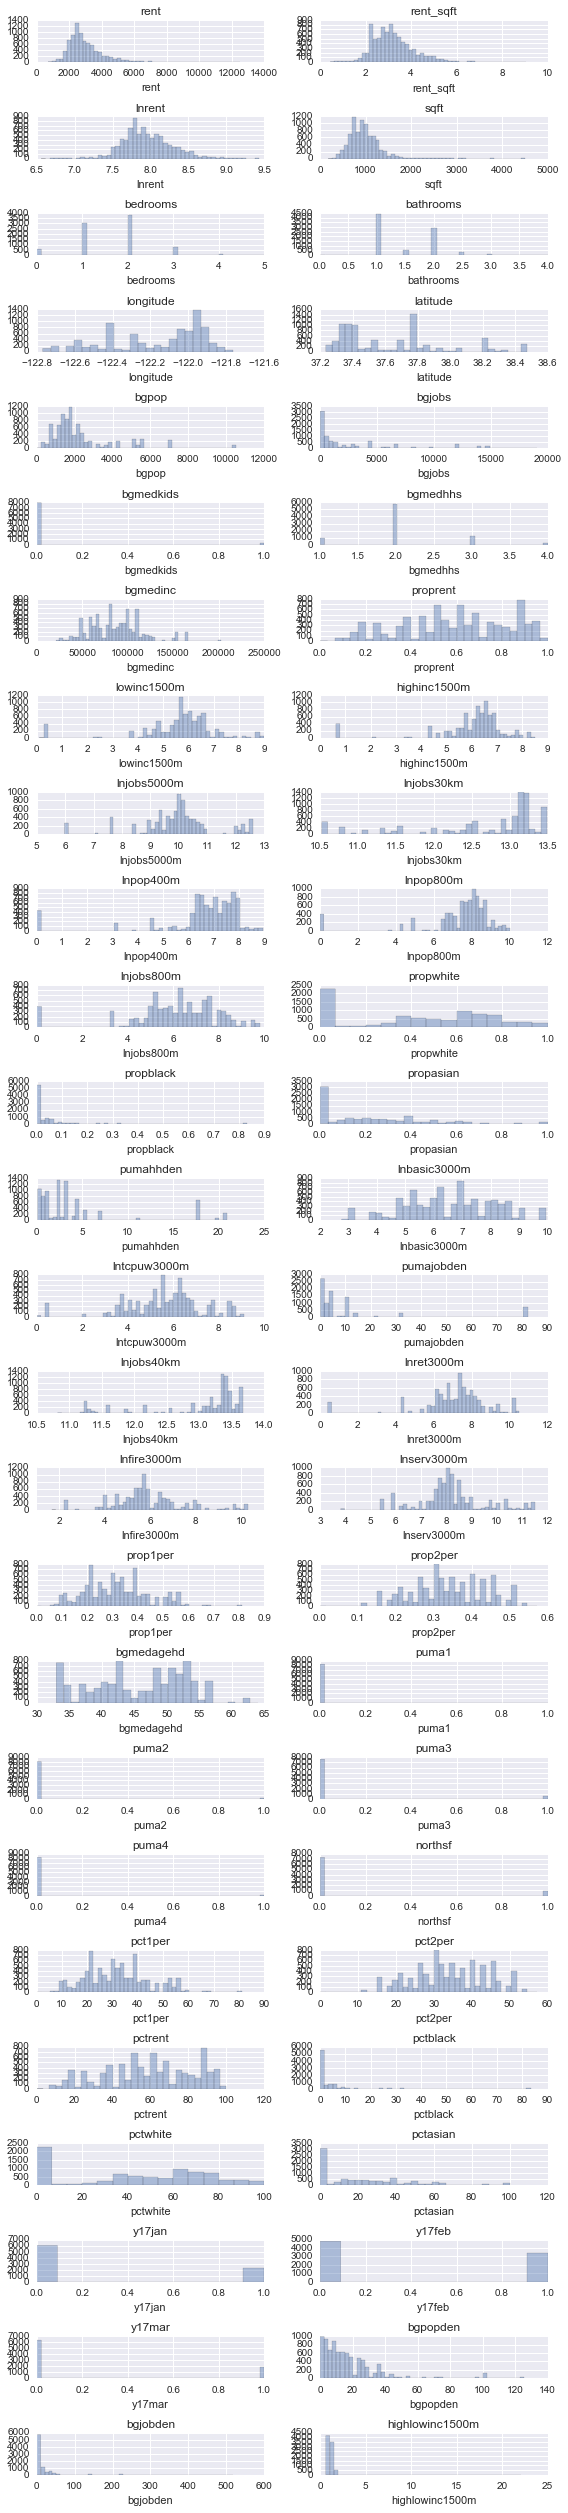

In [12]:
plot_rows = math.ceil(len(cols_to_use)/2)

f, axes = plt.subplots(plot_rows,2, figsize=(8,35))
sns.despine(left=True)

for i,col in enumerate(cols_to_use):
    row_position = math.floor(i/2)
    col_position = i%2
    sns.distplot(df_notnull[col], ax=axes[row_position, col_position],kde=False)
    axes[row_position, col_position].set_title('{}'.format(col)) 

plt.tight_layout()
plt.show()

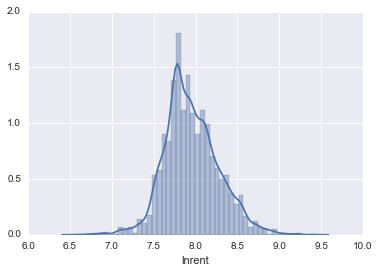

In [13]:
sns.distplot(df['lnrent'])

In [14]:
# $/sqft as a function of sqft 
#plt.scatter(df.sqft, df.rent_sqft)
#plt.ylabel('rent per sq ft')
#plt.xlabel('sqft')
#plt.show()

### Create some additional features that might help

(Second iteration)

In the first iteration of models, there appeared to be an interaction effect with # bedrooms and # bathrooms; i.e., the number of bathrooms per bedroom seems to matter. E.g., a property with 4 bedrooms is probably not very desirable if it only has 1 bathroom, but might be much more desirable if it has 4 bedrooms and 3 bathrooms. So let's try adding a feature for bathrooms per bedroom.  (Turns out this improved the linear model but not GB.. as expected.)

In [15]:
def bath_var(row):
    """Make bathrooms/bedroom variable. """
    # Avoid 0 in demoninator. When bedrooms = 0, it's probably a studio. so for practical purposes, br=1
    if row['bedrooms']==0:
        br = 1
    else:
        br = row['bedrooms']
    return row['bathrooms']/br

# add a variable bath_bed (bathrooms per bedroom)
df['bath_bed'] = df.apply(bath_var, axis=1)
cols_to_use.append('bath_bed')
x_cols.append('bath_bed')

It also appears the relationship between rent and sqft is not linear. Let's add a sqft2 term

In [16]:
df['sqft2'] = df['sqft']**2
cols_to_use.append('sqft2')
x_cols.append('sqft2')

# Linear model

Try a linear model first, at the very least to use as a baseline.

In [31]:
from sklearn import linear_model, model_selection

In [36]:
print('target variable:',y_col)
X_train, X_test, y_train, y_test = model_selection.train_test_split(df[x_cols],df[y_col], test_size = .3, random_state = 201)

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

target variable: lnrent


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [ ]:
# Intercept
print('Intercept:', regr.intercept_)

# The coefficients
print('Coefficients:')
pd.Series(regr.coef_, index=x_cols)

These coefficients aren't very useful without the standard errors. If I were interested in building a model for interpretation, I would use the statsmodels package, which has more functionality for statistical tests.

In [41]:
from sklearn.metrics import r2_score
# See mean square error, using test data
print("Mean squared error: %.2f" % np.mean((regr.predict(X_test) - y_test) ** 2))
print("RMSE:", np.sqrt(np.mean((regr.predict(X_test) - y_test) ** 2)))
# Explained variance score: 1 is perfect prediction. 
print('Variance score: %.2f' % regr.score(X_test, y_test))
# R2
print('R2:',r2_score(y_test, regr.predict(X_test)))

Mean squared error: 0.03
RMSE: 0.175778312162
Variance score: 0.71
R2: 0.712132308323


Scores for full dataset w/o bathrooms feature
- Mean squared error: 0.03
- RMSE: 0.186277629605
- Variance score: 0.68


Scores w/ bathrooms feature, dropping missing values - slightly better

- Mean squared error: 0.03
- RMSE: 0.181372180936
- Variance score: 0.69

Scores w/ bath_bed and sqft^2 features added

- Mean squared error: 0.03
- RMSE: 0.175778312162
- Variance score: 0.71

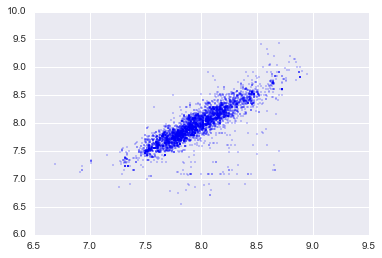

In [42]:
# It's a good idea to look at the residuals to make sure we don't have any gross violations of OLS
# Plot predicted values vs. observed
plt.scatter(regr.predict(X_train),y_train, color='blue',s=1, alpha=.5)
plt.show()

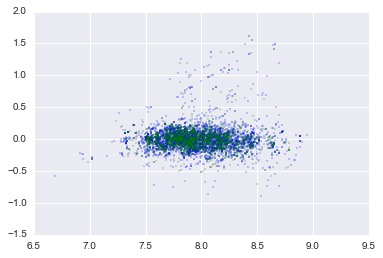

In [43]:
# plot residuals vs predicted values
plt.scatter(regr.predict(X_train), regr.predict(X_train)- y_train, color='blue',s=1, alpha=.5)
plt.scatter(regr.predict(X_test), regr.predict(X_test)- y_test, color='green',s=1, alpha=.5)
plt.show()

In [44]:
print("Training set. Mean squared error: %.5f" % np.mean((regr.predict(X_train) - y_train) ** 2), '| Variance score: %.5f' % regr.score(X_train, y_train))
print("Test set. Mean squared error: %.5f" % np.mean((regr.predict(X_test) - y_test) ** 2), '| Variance score: %.5f' % regr.score(X_test, y_test))

Training set. Mean squared error: 0.02863 | Variance score: 0.72516
Test set. Mean squared error: 0.03090 | Variance score: 0.71213


Does not look like overfitting. (If there were, we'd probably have a much smaller error on training set and a larger error on test set.')
We do have a problem with colinearity and if we were using this model for interpretation we'd have to do better feature selection...

# Gradient boosting

In [17]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [18]:
def RMSE(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

def cross_val_gb(X,y,cv_method='kfold',k=5, **params):
    """Estimate gradient boosting regressor using cross validation.
    
    Args: 
        X (DataFrame): features data
        y (Series): target data
        cv_method (str): how to split the data ('kfold' (default) or 'timeseries')
        k (int): number of folds (default=5)
        **params: keyword arguments for regressor
    Returns: 
        float: mean error (RMSE) across all training/test sets.
    """
    if cv_method == 'kfold':
        kf = KFold(n_splits=k, shuffle=True, random_state=2012016)  # use random seed for reproducibility. 
    
    E = np.ones(k)   # this array will hold the errors. 
    i=0
    for train, test in kf.split(X, y): 
        train_data_x = X.iloc[train]
        train_data_y = y.iloc[train]    
        test_data_x = X.iloc[test]
        test_data_y = y.iloc[test]

        # n_estimators is number of trees to build. 
        grad_boost = GradientBoostingRegressor(loss='ls',criterion='mse', **params)
        grad_boost.fit(train_data_x,train_data_y)
        predict_y=grad_boost.predict(test_data_x)
        E[i] = RMSE(test_data_y, predict_y)
        i+=1
    return np.mean(E)


In [17]:
df_X = df[x_cols]
df_y = df[y_col]

Index(['sqft', 'bedrooms', 'bathrooms', 'longitude', 'latitude', 'bgpop',
       'bgjobs', 'bgmedkids', 'bgmedhhs', 'bgmedinc', 'proprent',
       'lowinc1500m', 'highinc1500m', 'lnjobs5000m', 'lnjobs30km', 'lnpop400m',
       'lnpop800m', 'lnjobs800m', 'propwhite', 'propblack', 'propasian',
       'pumahhden', 'lnbasic3000m', 'lntcpuw3000m', 'pumajobden', 'lnjobs40km',
       'lnret3000m', 'lnfire3000m', 'lnserv3000m', 'prop1per', 'prop2per',
       'bgmedagehd', 'puma1', 'puma2', 'puma3', 'puma4', 'northsf', 'pct1per',
       'pct2per', 'pctrent', 'pctblack', 'pctwhite', 'pctasian', 'y17jan',
       'y17feb', 'y17mar', 'bgpopden', 'bgjobden', 'highlowinc1500m',
       'bath_bed', 'sqft2'],
      dtype='object')

Tune the parameters for GB

In [20]:
params = {'n_estimators':100,
          'learning_rate':0.1,
          'max_depth':1,
          'min_samples_leaf':4
          }
grad_boost = GradientBoostingRegressor(loss='ls',criterion='mse', **params)
grad_boost.fit(df_X,df_y)
cross_val_gb(df_X,df_y, **params)

0.17768555628211918

In [193]:
param_grid = {'learning_rate':[.5 ,.1, .05],
              'max_depth':[2,4,6,12],
              'min_samples_leaf': [5,9,17],
              'max_features': [1, .3, .1]
              }

est= GradientBoostingRegressor(n_estimators = 500)
gs_cv = GridSearchCV(est,param_grid).fit(df_X,df_y)

In [194]:
print(gs_cv.best_params_)
print(gs_cv.best_score_)

{'max_depth': 2, 'learning_rate': 0.05, 'min_samples_leaf': 17, 'max_features': 0.3}
0.612986032534


In [189]:
param_grid = {'learning_rate':[5,.2,.1],
              'max_depth':[6,8,12],
              'min_samples_leaf': [17,25],
              'max_features': [.3]
              }

#est= GradientBoostingRegressor(n_estimators = 100)
#gs_cv = GridSearchCV(est,param_grid).fit(df_X,df_y)

In [99]:
print(gs_cv.best_params_)
print(gs_cv.best_score_)

{'max_depth': 12, 'learning_rate': 0.1, 'min_samples_leaf': 17, 'max_features': 0.3}
0.539942208017


In [196]:
# best parameters
params = {'n_estimators':500,
          'learning_rate':0.1,
          'max_depth':4,
          'min_samples_leaf':9,
          'max_features':.3
          }
grad_boost = GradientBoostingRegressor(loss='ls',criterion='mse', **params)
grad_boost.fit(df_X,df_y)
cross_val_gb(df_X,df_y, **params, k=3)

0.13212563068130101

Best RMSE when using no bathrooms: 0.1308920

Best RMSE with bathrooms feature: 0.132212

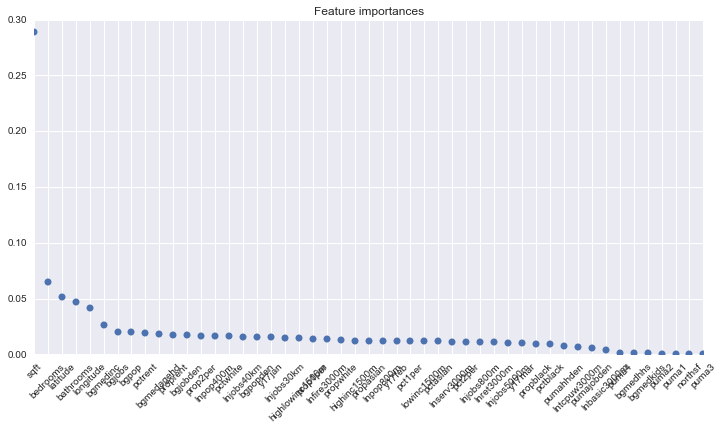

In [197]:
# plot the importances
gb_o = pd.DataFrame({'features':x_cols,'importance':grad_boost.feature_importances_})
gb_o= gb_o.sort_values(by='importance',ascending=False)


plt.figure(1,figsize=(12, 6))
plt.xticks(range(len(gb_o)), gb_o.features,rotation=45)
plt.plot(range(len(gb_o)),gb_o.importance,"o")
plt.title('Feature importances')
plt.show()

In [198]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

In [23]:
#for i,col in enumerate(df_X.columns): 
#    print(i,col)

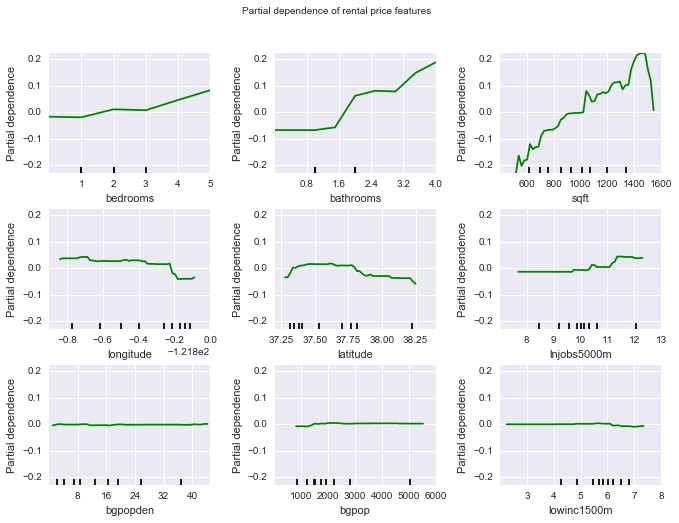

In [202]:
features = [0,1,2,3,4, 13, 46,5,11]
names = df_X.columns
fig, axs = plot_partial_dependence(grad_boost, df_X, features,feature_names=names, grid_resolution=50, figsize = (10,8))
fig.suptitle('Partial dependence of rental price features')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle
plt.show()

//anaconda/lib/python3.5/site-packages/matplotlib/contour.py:380: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


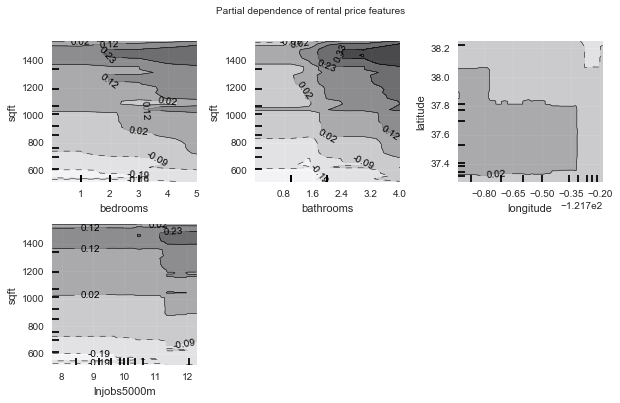

In [204]:
features = [(0,2),(1,2),(3,4),(13,2)]
names = df_X.columns
fig, axs = plot_partial_dependence(grad_boost, df_X, features,feature_names=names, grid_resolution=50, figsize = (9,6))
fig.suptitle('Partial dependence of rental price features')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle
plt.show()

## Using $/sqft as target variable

What if we use price per sqft as the y variable? Makes more sense conceptually. 



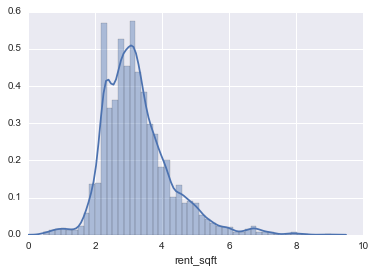

In [21]:
y_col = 'rent_sqft'
df_y = df[y_col]

x_cols = cols_to_use[3:]
df_X = df[x_cols]
sns.distplot(df['rent_sqft'])

Downside is that the distribution is not as normally distributed. It's not that bad though.

### Linear model with $/sqft as target

In [52]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df[x_cols],df[y_col], test_size = .3, random_state = 201)

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [54]:
# Intercept
#print('Intercept:', regr.intercept_)

# The coefficients
#print('Coefficients:')
#pd.Series(regr.coef_, index=x_cols)

In [56]:
# See mean square error, using test data
print("Mean squared error: %.2f" % np.mean((regr.predict(X_test) - y_test) ** 2))
print("RMSE:", np.sqrt(np.mean((regr.predict(X_test) - y_test) ** 2)))
# Explained variance score: 1 is perfect prediction. 
print('Variance score: %.2f' % regr.score(X_test, y_test))
print('R2:',r2_score(y_test, regr.predict(X_test)))

Mean squared error: 0.28
RMSE: 0.526323190891
Variance score: 0.73
R2: 0.732591555545


Since the rent_sqft has a different scale than lnrent, we can't directly compare the RMSE, but we can compare variance score. This variance (0.66) is a bit lower than the linear model before (0.69), which is what we'd expect when we take the most important covariate and put it into the target variable. Still not a bad score here. Not great either, though. 

Added sqft as feature, with rent_sqft still as target: 
- Mean squared error: 0.32
- RMSE: 0.56438373549
- Variance score: 0.69

Added bath/bedrooms feature

- Mean squared error: 0.31
- RMSE: 0.559876928818
- Variance score: 0.70

Added sqft^2 feature

- Mean squared error: 0.28
- RMSE: 0.526323190891
- Variance score: 0.73

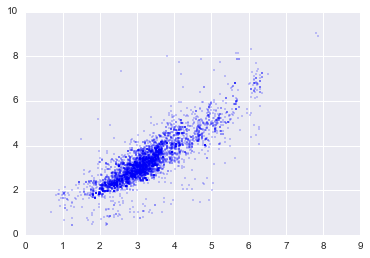

In [57]:
# Plot predicted values vs. observed
plt.scatter(regr.predict(X_train),y_train, color='blue',s=1, alpha=.5)
plt.show()

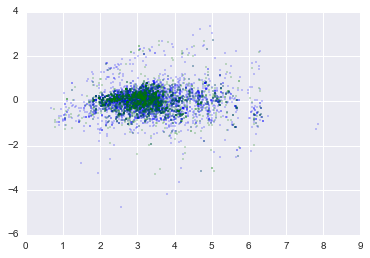

In [58]:
# plot residuals vs predicted values
plt.scatter(regr.predict(X_train), regr.predict(X_train)- y_train, color='blue',s=1, alpha=.5)
plt.scatter(regr.predict(X_test), regr.predict(X_test)- y_test, color='green',s=1, alpha=.5)
plt.show()

### Gradient boosting with $/sqft as target

In [22]:
# because GB can model nonlinear relationships and interaction effects, we don't need sqft^2 or bed_bath as features. 
x_cols = ['sqft','bedrooms','bathrooms','longitude', 'latitude','bgpop','bgjobs', 'bgmedkids', 'bgmedhhs',
       'bgmedinc', 'proprent', 'lowinc1500m', 'highinc1500m', 'lnjobs5000m','lnjobs30km', 'lnpop400m', 'lnpop800m', 'lnjobs800m', 'propwhite',
       'propblack', 'propasian', 'pumahhden', 'lnbasic3000m', 'lntcpuw3000m','pumajobden', 'lnjobs40km', 'lnret3000m', 'lnfire3000m', 'lnserv3000m',
       'prop1per', 'prop2per', 'bgmedagehd', 'puma1', 'puma2', 'puma3','puma4', 'northsf', 'pct1per', 'pct2per', 'pctrent',
       'pctblack', 'pctwhite', 'pctasian', 'y17jan', 'y17feb', 'y17mar','bgpopden', 'bgjobden', 'highlowinc1500m']

df_X = df[x_cols]
y_col = 'rent_sqft'
df_y = df[y_col]
df_X.shape

(8253, 49)

In [23]:
params = {'n_estimators':100,
          'learning_rate':0.1,
          'max_depth':1,
          'min_samples_leaf':4
          }
#grad_boost = GradientBoostingRegressor(loss='ls',criterion='mse', **params)
#grad_boost.fit(df_X,df_y)
#cross_val_gb(df_X,df_y, **params)

Without parameter tuning, error is about the same as linear model. RMSE: 0.5947

** Adding sqft as covariate **: RMSE: 0.5258

**Tune the parameters**

In [24]:
# find the optimal parameters
param_grid = {'learning_rate':[.5 ,.1, .05],
              'max_depth':[2,4,6,12],
              'min_samples_leaf': [5,9,17],
              'max_features': [1, .3, .1]
              }

#est= GradientBoostingRegressor(n_estimators = 500)
#gs_cv = GridSearchCV(est,param_grid).fit(df_X,df_y)

In [25]:
print(gs_cv.best_params_)
print(gs_cv.best_score_)

NameError: name 'gs_cv' is not defined

In [26]:
# run with best paramters
params = {'n_estimators':500,
          'learning_rate':0.05,
          'max_depth':2,
          'min_samples_leaf':5,
          'max_features':.3
          }
#grad_boost = GradientBoostingRegressor(loss='ls',criterion='mse', **params)
#grad_boost.fit(df_X,df_y)
#cross_val_gb(df_X,df_y, **params, k=3)

In [27]:
# best parameters, using 1000 estimators
params = {'n_estimators':1000,
          'learning_rate':0.05,
          'max_depth':2,
          'min_samples_leaf':5,
          'max_features':.3
          }
grad_boost = GradientBoostingRegressor(loss='ls',criterion='mse', **params)
grad_boost.fit(df_X,df_y)
cross_val_gb(df_X,df_y, **params, k=3)

0.40539199896246719

In [28]:
import pickle
# save as pickle for web app
fname = 'fitted_gb.p'
with open(os.path.join(DATA_DIR,fname), 'wb') as pfile:
    pickle.dump(grad_boost, pfile)

In [35]:
# to load the pickled object: 
fname = 'fitted_gb.p'
with open(os.path.join(DATA_DIR,fname), 'rb') as pfile:
    grad_boost2 = pickle.load(pfile)

In [32]:
# save median/mean feature values to use as defaults in the web app
df_means = df_X.mean()
fname = 'data_averages.p'
with open(os.path.join(DATA_DIR, fname), 'wb') as pfile: 
    pickle.dump(df_means, pfile)

In [36]:
# to load the pickled object: 
fname = 'data_averages.p'
with open(os.path.join(DATA_DIR,fname), 'rb') as pfile:
    df_means2 = pickle.load(pfile)
print(df_means2.head())

sqft         969.239428
bedrooms       1.620380
bathrooms      1.481764
longitude   -122.166756
latitude      37.628084
dtype: float64


In [42]:
# testing prediction
y_predicted = grad_boost2.predict(df_means2)
print(y_predicted)
print(df_y.mean())

[ 3.39677989]
3.2427675728367986


//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


**without sqft as covariate**
- RMSE with 500 estimators: 0.4708
- RMSE with 1000 estimators: 0.4658
- linear model: 0.5965


**with sqft as covariate**
- RMSE with 500 estimators: 0.3503
- RMSE with 1000 estimators: 0.3508
- linear model: 0.5644


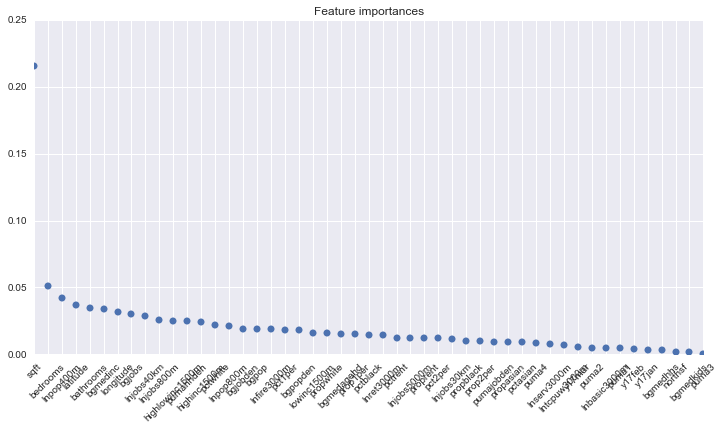

In [81]:
# plot the importances
gb_o = pd.DataFrame({'features':x_cols,'importance':grad_boost.feature_importances_})
gb_o= gb_o.sort_values(by='importance',ascending=False)


plt.figure(1,figsize=(12, 6))
plt.xticks(range(len(gb_o)), gb_o.features,rotation=45)
plt.plot(range(len(gb_o)),gb_o.importance,"o")
plt.title('Feature importances')
plt.show()

In [82]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

In [83]:
# choose features for partial dependent plots
#for i,col in enumerate(df_X.columns): 
 #   print(i,col)

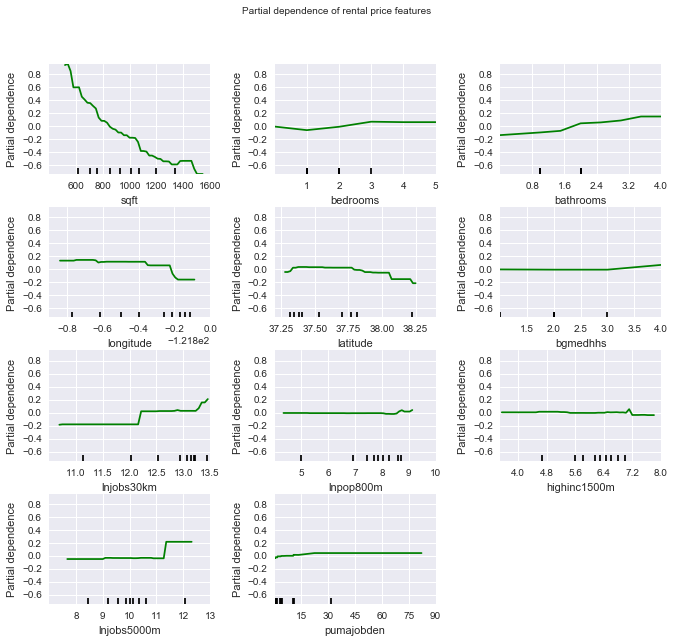

In [99]:
features = [0,1,2,3,4,8,14,16,12,13,24]
names = df_X.columns
fig, axs = plot_partial_dependence(grad_boost, df_X, features,feature_names=names, grid_resolution=50, figsize = (10,10))
fig.suptitle('Partial dependence of rental price features')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle
plt.show()

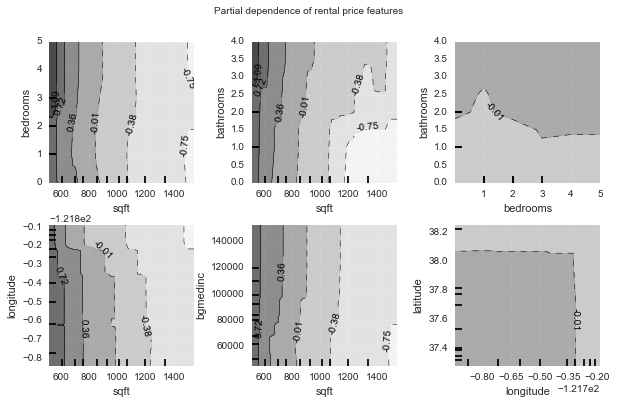

In [100]:
features = [(0,1),(0,2),(1,2),(0,3),(0,9),(3,4)]
names = df_X.columns
fig, axs = plot_partial_dependence(grad_boost, df_X, features,feature_names=names, grid_resolution=50, figsize = (9,6))
fig.suptitle('Partial dependence of rental price features')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle
plt.show()

Looks like bathrooms per bedroom might be a good feature to add. Tried this; it made the linear model better but the gradient boosting worse. Maybe because the GB already takes interactiion effects into account.

## Error analysis
- plot errors
- map errors by long/lat

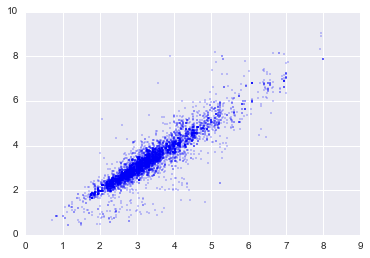

In [255]:
y_pred = grad_boost.predict(df_X)
# plot predicted vs. actual

plt.scatter(y_pred,df_y, color='blue',s=1, alpha=.5)
plt.show()

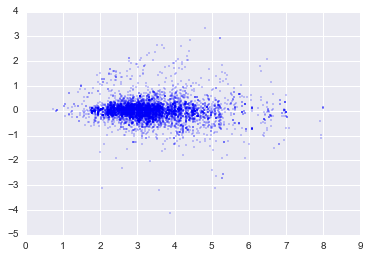

In [256]:
# plot errors vs. predicted
plt.scatter(y_pred, y_pred-df_y, color='blue',s=1,alpha=.5 )
plt.show()

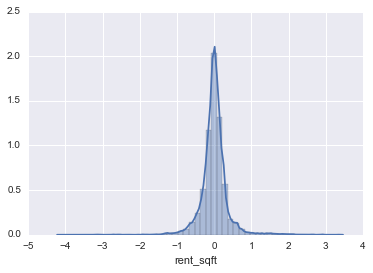

In [257]:
sns.distplot(y_pred-df_y)

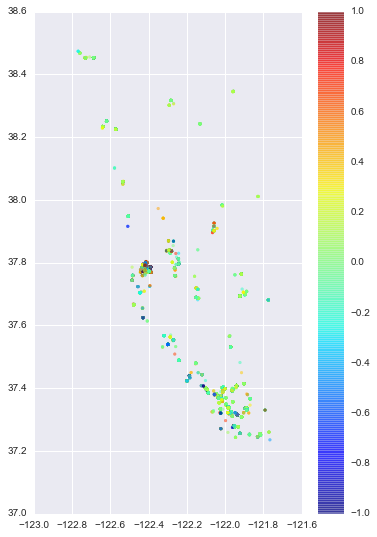

In [260]:
from matplotlib.colors import Normalize
# map the errors. 
x = df_X['longitude']
y = df_X['latitude']
z = y_pred-df_y

norm = Normalize(vmin=-1,vmax=1)  # zoom in on middle of error range

plt.figure(figsize=(6,9))
plt.scatter(x,y, c=z, cmap='jet',s=8,alpha=.5,edgecolors='face', norm=norm)
#plt.xlim(-122.6,-122)
#plt.ylim(37.6,38)
plt.colorbar()
plt.show()

# obs where abs(error)>0.8: 320


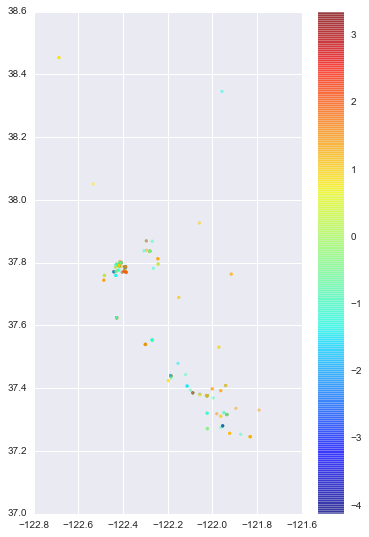

In [261]:
# it's hard to see a pattern in the above, but looks like errors are larger in the central city areas. 
# only show large errors, to make them more clear. 
# map the errors. 

err_cutoff = .8
print('# obs where abs(error)>{}:'.format(err_cutoff),len(z[abs(z)>err_cutoff]))
z_large_err = z[abs(z)>err_cutoff]
x_large_err = x.ix[z_large_err.index,]
y_large_err = y.ix[z_large_err.index,]


plt.figure(figsize=(6,9))
plt.scatter(x_large_err,y_large_err, c=z_large_err, cmap='jet',s=8,alpha=.5,edgecolors='face')

plt.colorbar()
plt.show()

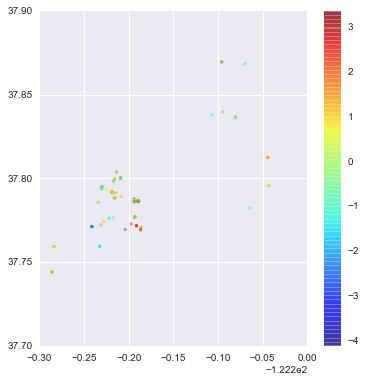

In [262]:
plt.figure(figsize=(6,6))
plt.scatter(x_large_err,y_large_err, c=z_large_err, cmap='jet',s=8,alpha=.5,edgecolors='face')
plt.xlim(-122.5,-122.2)
plt.ylim(37.7,37.9)
plt.colorbar()
plt.show()

I can't find a clear spatial pattern with the errors. Can try with real map... 



## Write to database for use in rent-predictor app

In [31]:
# this particular dataset is a subset of all the features available
infile = 'ba_block_small.csv'
df = pd.read_csv(os.path.join(DATA_DIR,infile), dtype={'fips_block':str})
df = df.ix[:,1:]  # exclude first column, which was empty
print(df.shape)
df.head()

(16560, 70)


,pid,date,region,neighborhood,rent,bedrooms,sqft,rent_sqft,longitude,latitude,...,pctrent,pctblack,pctwhite,pctasian,y17jan,y17feb,y17mar,bgpopden,bgjobden,highlowinc1500m
0,5873897352,2016-11-13,sfbay,dublin / pleasanton / livermore,2250.0,1.0,687.0,3.275109,-121.888125,37.708458,...,64.434687,0.0,0.0,0.0,False,False,False,10.073916,7.875687,1.504727
1,5875136804,2016-11-14,sfbay,dublin / pleasanton / livermore,1995.0,1.0,687.0,2.903930,-121.888125,37.708458,...,64.434687,0.0,0.0,0.0,False,False,False,10.073916,7.875687,1.504727
2,5869197992,2016-11-15,sfbay,dublin / pleasanton / livermore,2395.0,1.0,817.0,2.931457,-121.888125,37.708458,...,64.434687,0.0,0.0,0.0,False,False,False,10.073916,7.875687,1.504727
3,5885759159,2016-11-20,sfbay,dublin / pleasanton / livermore,2250.0,1.0,687.0,3.275109,-121.888125,37.708458,...,64.434687,0.0,0.0,0.0,False,False,False,10.073916,7.875687,1.504727
4,5886665547,2016-11-21,sfbay,dublin / pleasanton / livermore,1995.0,1.0,629.0,3.171701,-121.888125,37.708458,...,64.434687,0.0,0.0,0.0,False,False,False,10.073916,7.875687,1.504727


In [37]:
fips_list = df['fips_block'].unique()
len(fips_list)

262

In [45]:
cols_for_db = ['pid','fips_block','latitude','longitude']
df[cols_for_db].to_csv('/Users/lisarayle/rent_predictor/local_setup_files/data/ba_data_temp.csv', index=False)

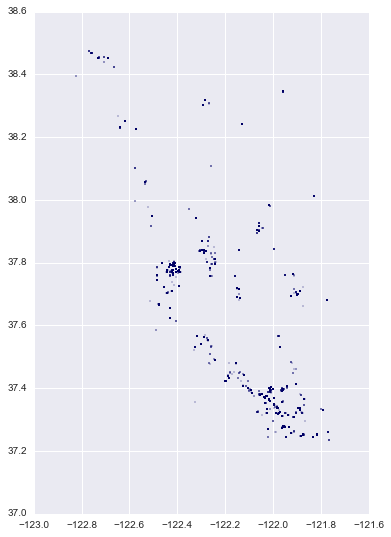

In [42]:

# map the errors. 
x = df['longitude']
y = df['latitude']

plt.figure(figsize=(6,9))
plt.scatter(x,y,s=1,alpha=.5)
#plt.xlim(-122.6,-122)
#plt.ylim(37.6,38)

plt.show()